<a href="https://colab.research.google.com/github/C0RD3LL/Omics/blob/main/PlantscRNA_SeqData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q scanpy

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import scanpy as sc 

from sklearn.cluster import KMeans

In [3]:
shr = pd.read_csv("https://zenodo.org/record/4597857/files/GSE123818_Root_single_cell_shr_datamatrix.fixednames.transposed.csv.gz",index_col= 0)
wt = pd.read_csv("https://zenodo.org/record/4597857/files/GSE123818_Root_single_cell_wt_datamatrix.fixednames.transposed.csv.gz", index_col = 0)

Shapes
- shr   (1099,27629)
- wt    (4727,27629)
- total (5826,27629)

In [4]:
a = sc.AnnData(X = shr)
b = sc.AnnData(X= wt)
adata = sc.AnnData.concatenate(b,a, batch_key = 'batch', batch_categories= ["wt","shr"])

In [5]:
qc = sc.pp.calculate_qc_metrics(adata)

cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('This is the cell quality control dataframe:')
display(cell_qc_dataframe.head())

print('\n\n\n\nThis is the gene quality control dataframe:')
display(gene_qc_dataframe.head())

This is the cell quality control dataframe:


,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCTGCACTTAACG-1-wt,3717,8.220941,12716.0,9.450695,22.192513,31.503617,41.978610,57.958478
AAACCTGCAGGACGTA-1-wt,4235,8.351375,15249.0,9.632335,23.844187,31.916847,41.261722,56.764378
AAACCTGTCAGGTAAA-1-wt,3257,8.088869,10391.0,9.248792,25.348860,33.731113,43.104610,59.387932
AAACGGGCAATAGAGT-1-wt,9658,9.175645,157717.0,11.968564,16.906231,26.418205,38.628683,57.487145
AAACGGGCACTTGGAT-1-wt,9483,9.157361,127039.0,11.752257,14.392431,21.265123,31.336046,49.575327






This is the gene quality control dataframe:


,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AT1G01010,915,0.266392,0.236172,84.294542,1552.0,7.347944
AT1G01020,2041,0.673876,0.515142,64.967388,3926.0,8.275631
AT1G01030,551,0.155853,0.144839,90.542396,908.0,6.812345
AT1G01040,616,0.126674,0.119270,89.426708,738.0,6.605298
AT1G01050,4271,6.045314,1.952363,26.690697,35220.0,10.469398


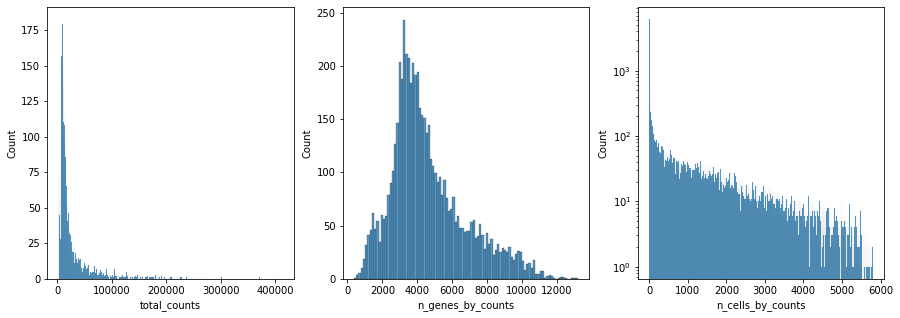

In [6]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.histplot(cell_qc_dataframe['total_counts'], bins=1000,ax=axes[0])

sns.histplot(cell_qc_dataframe['n_genes_by_counts'], bins=100,ax=axes[1])

sns.histplot(gene_qc_dataframe['n_cells_by_counts'], bins=1000,ax=axes[2],log_scale=(False,True))

plt.show()

#sns.histplot(cell_qc_dataframe['total_counts'], bins=1000)
#plt.xlabel('Total counts')
#plt.ylabel('N cells')

#plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
#plt.xlabel('N genes')
#plt.ylabel('N cells')

#plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
#plt.xlabel('N cells expressing > 0')
#plt.ylabel('log(N genes)') # for visual clarity
#plt.axvline(2, color='red')
#plt.yscale('log')

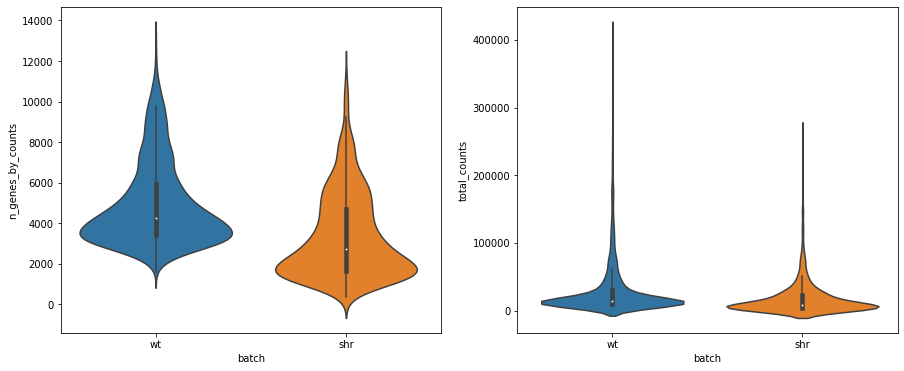

In [7]:
f, axes = plt.subplots(1,2, figsize=(15,6))

sns.violinplot(y = cell_qc_dataframe['n_genes_by_counts'], x = adata.obs["batch"], ax = axes[0])
sns.violinplot(y = cell_qc_dataframe['total_counts'], x = adata.obs["batch"], ax = axes[1])

#Filter
Most scRNA-seq datasets need to set a minimum threshold of detectability in order to ensure that the cells are of high enough quality to be used for analysis. Conversely, sometimes an upper threshold also should be set to counter the case where a cell is a cell-doublet (in the sense that two cells were captured and sequenced accidentally as a single cell).

The above violin plots suggest quite a few outliers, mostly on the upper-end of the density plots, suggesting a few cell-doublets in the data. The effect of these is not something we cannot easily regress out, and so we must filter them out instead. By looking at the plots, we can see that a good maximum library size here would be 100 000 transcripts, and a good maximum feature size would be 10 000 transcripts.

For this analysis, we will set a minimum threshold of detectability that each cell should count transcripts from at least 200 genes, and that each gene should be expressed in at least 5 cells. These lower-bound thresholds are not so easy to derive from such QC plots, but depend mostly on the type of data you are using. If the number of features and the library sizes were one order of magnitude higher, one might consider also scaling the lower-bound thresholds by one order of magnitude.

In [8]:
sc.pp.filter_cells(adata,min_genes=100)
sc.pp.filter_cells(adata,max_genes=12000)
sc.pp.filter_genes(adata, min_cells = 2)
sc.pp.filter_cells(adata,max_counts= 120000)
qc = sc.pp.calculate_qc_metrics(adata)

cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

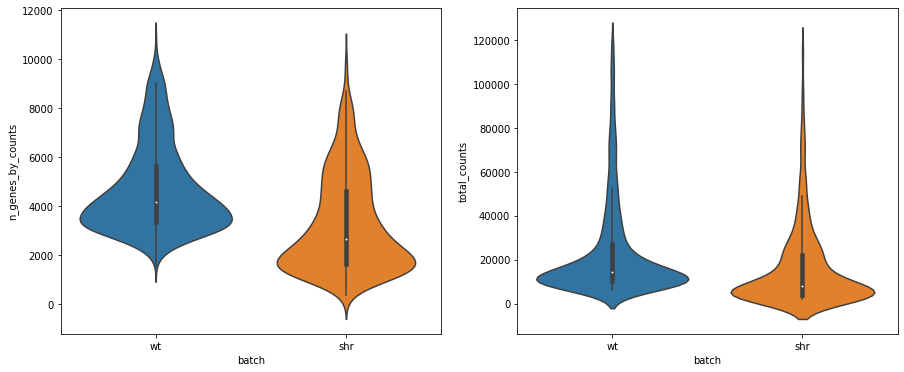

In [9]:
f, axes = plt.subplots(1,2, figsize=(15,6))

sns.violinplot(y = cell_qc_dataframe['n_genes_by_counts'], x = adata.obs["batch"], ax = axes[0])
sns.violinplot(y = cell_qc_dataframe['total_counts'], x = adata.obs["batch"], ax = axes[1])

In [10]:
adata.shape
# its supposed to be (5826,18913)

(5623, 23085)

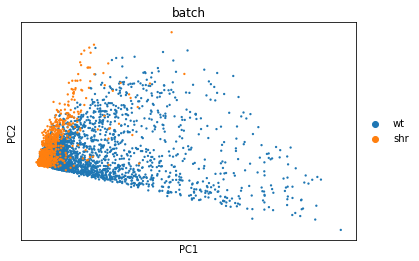

In [11]:
sc.pp.pca(adata)
sc.pl.pca(adata, color= "batch")

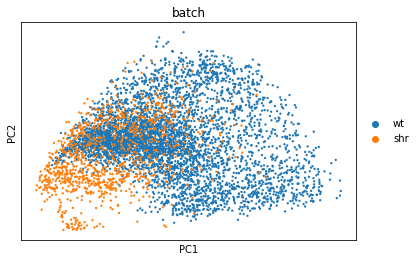

In [12]:
adata_cpm = adata.copy() # apply this to a copy so we can compare methods
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_cpm, 
                         counts_per_cell_after=1e6)

sc.pp.log1p(adata_cpm)
sc.pp.scale(adata_cpm)

sc.pp.pca(adata_cpm)
sc.pl.pca(adata_cpm, color= "batch")

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


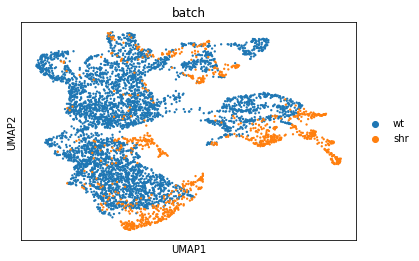

In [13]:
sc.pp.neighbors(adata_cpm)
sc.tl.umap(adata_cpm) 
sc.pl.umap(adata_cpm, color='batch')

... storing 'kmeans' as categorical


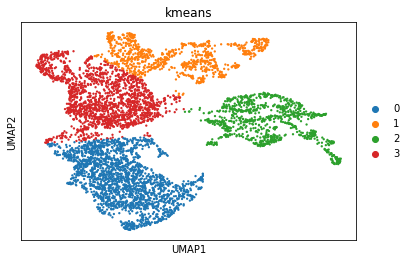

In [23]:
umap_coordinates = adata_cpm.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata_cpm.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata_cpm.obs['kmeans'] = adata_cpm.obs['kmeans'].astype(str)

sc.pl.umap(adata_cpm, color='kmeans')

In [15]:
pip install -q leidenalg

In [17]:
sc.tl.leiden(adata_cpm,resolution = 0.35)

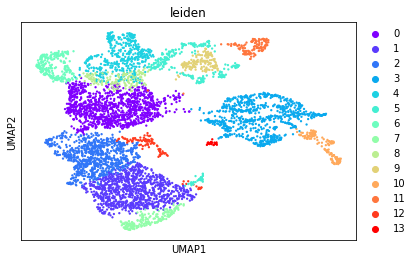

In [18]:
sc.pl.umap(adata_cpm,color = ['leiden'],palette='rainbow')

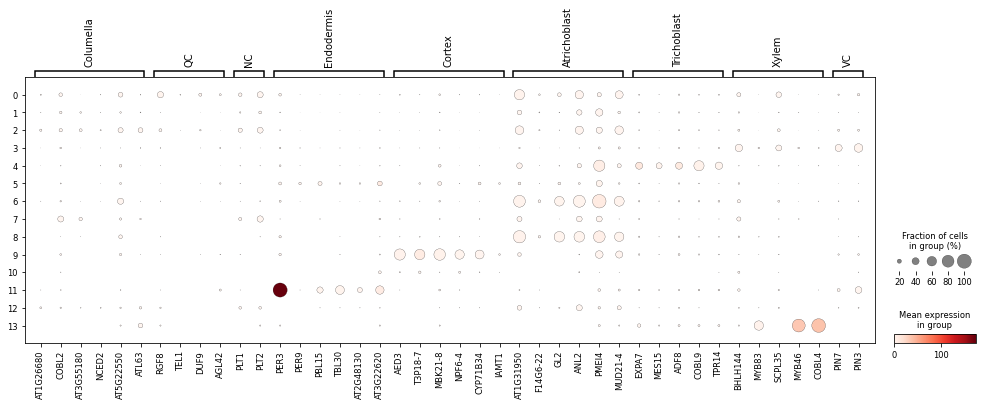

In [19]:
var_names = ['AT1G26680','COBL2','AT3G55180','NCED2','AT5G22550','ATL63','RGF8','TEL1','DUF9','AGL42',
             'PLT1','PLT2','PER3','PER9','PBL15','TBL30','AT2G48130','AT3G22620','AED3','T3P18-7',
             'MBK21-8','NPF6-4','CYP71B34','IAMT1','AT1G31950','F14G6-22','GL2','ANL2','PMEI4',
             'MUD21-4','EXPA7','MES15','ADF8','COBL9','TPR14','BHLH144','MYB83','SCPL35','MYB46',
             'COBL4','PIN7','PIN3']


sc.pl.dotplot(adata_cpm, var_names= var_names ,groupby="leiden", use_raw=True,
              num_categories=9,
              var_group_labels = ["Columella","QC","NC","Endodermis","Cortex","Atrichoblast","Trichoblast","Xylem","VC"], 
              var_group_positions=[(0,5),(6,9),(10,11),(12,17),(18,23),(24,29),(30,34),(35,39),(40,41)])
#sc.pl.dotplot(adata_cpm, var_names= var_names ,groupby="kmeans")

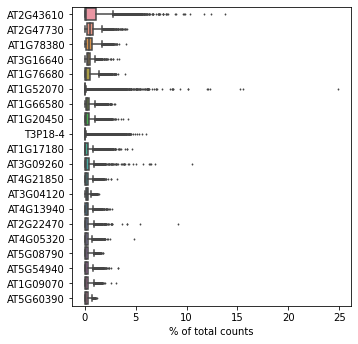

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [21]:
adata_cpm.obs["leiden"].cat.categories = ['cell_type1','cell_type2','cell_type3',
                                          'cell_type4','cell_type5','cell_type6',
                                          'cell_type7','cell_type8','cell_type9',
                                          'cell_typex','cell_typexi','cell_typexii',
                                          'cell_typexiii','cell_typexiv']

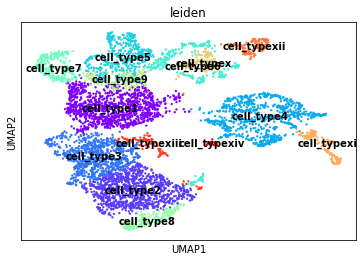

In [22]:
sc.pl.umap(adata_cpm,color = ['leiden'],palette='rainbow', legend_loc='on data')

#Citations 
1. Mehmet Tekman, Beatriz Serrano-Solano, Cristóbal Gallardo, Pavankumar Videm, 2021 Analysis of plant scRNA-Seq Data with Scanpy (Galaxy Training Materials). https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/scrna-plant/tutorial.html Online; accessed Fri Nov 26 2021

2. Batut et al., 2018 Community-Driven Data Analysis Training for Biology Cell Systems 10.1016/j.cels.2018.05.012